# Generating parameter lists

# 1. Setup

In [1]:
%load_ext watermark
%load_ext autoreload

import pickle

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib as mpl
import matplotlib.pyplot as plt

import sys
sys.path.append('/glade/u/home/bbuchovecky/projects/cpl_ppe_co2/utils')
import cpl_ppe_co2 as ppe
%aimport cpl_ppe_co2
%autoreload 1

%watermark -iv -co -v

Python implementation: CPython
Python version       : 3.12.10
IPython version      : 9.2.0

conda environment: cpl_ppe_co2

numpy     : 2.0.1
xarray    : 2025.4.0
pandas    : 2.2.2
matplotlib: 3.9.1
sys       : 3.12.10 | packaged by conda-forge | (main, Apr 10 2025, 22:21:13) [GCC 13.3.0]



## 1.1 Load color dictionaries

In [2]:
mpl.rcParams['figure.dpi'] = 150

with open('./top26_param_colors.pkl', 'rb') as f:
    pscs26_dict = pickle.load(f)
    pscs26 = list(pscs26_dict.values())

with open('./top12_param_colors.pkl', 'rb') as f:
    pscs12_dict = pickle.load(f)
    pscs12 = list(pscs12_dict.values())

# 2. Load data

## 2.1 Variable name

In [3]:
variable = [
    'EFLX_LH_TOT',  # total evaporation
    'FCTR',         # canopy transpiration
    'FCEV',         # canopy evaporation
    'FGEV',         # ground evaporation
]

varname = {
    'EFLX_LH_TOT': 'Total Evapotranspiration',
    'FCTR': 'Canopy Transpiration',
    'FCEV': 'Canopy Evaporation',
    'FGEV': 'Ground Evaporation',
}

## 2.2 Master dataframes of CLM5 PPE rankings
`02_bgb_param-rank-diff-forc.ipynb`

In [4]:
clm5_rank = dict()
for var in variable:
    clm5_rank[var] = pd.read_csv(f'./rank/{var}_params_rank_all.csv')
clm5_key = list(clm5_rank[var].columns[1:])

### 2.2.1 Quick check
Compare my computations agains Daniel Kennedy's aggregated PPE dataset to check that the negative FCEV for `maximum_leaf_wetted_fraction`in boreal forest is correct -- **they're the same**

In [5]:
var = 'FCEV'
f = '/glade/u/home/djk2120/ppe_clean/postp/OAAT_surv.nc'
ds = xr.open_dataset(f)
dk_pftname = ds.pft_name
dk_biomename = ds.biome_name
ds = ds[[s for s in list(ds.keys()) if var in s]]  # select variables with v in name

In [6]:
bm = 'Boreal forest'
ibm = dk_biomename.where(dk_biomename==bm).dropna(dim='biome').biome.values

print(ds.FCEV_biome_mean.sel(param='maximum_leaf_wetted_fraction', minmax='min', exp='AF2095', biome=ibm).values)

df = pd.read_csv(f'./rank/csv/AF2095_top193_params_biomes.csv')
df.loc[df['param_name']=='maximum_leaf_wetted_fraction'].loc[df['variable']=='FCEV'].loc[df['variable']=='FCEV'].loc[df['biome']==bm]

[-0.83775849]


,param_name,biome,criteria,rank,variable,measure,xmin,xmax,range
10809,maximum_leaf_wetted_fraction,Boreal forest,FCEV_mean_Boreal forest,2,FCEV,mean,-0.837758,7.017051,7.854809
11019,maximum_leaf_wetted_fraction,Boreal forest,FCEV_iav_Boreal forest,19,FCEV,iav,0.500020,0.608696,0.108676


## 2.3 Parameter functional types

In [7]:
cat = pd.read_csv('./category.csv', header=None)
functype = list(cat[cat[1].isna()][0])
keys = cat[cat[1].notna()][1].unique()
funcdict = dict(zip(keys, functype))

pcat = dict()
for row in cat.iterrows():
    if type(row[1][1]) == str:
        key = funcdict[row[1][1]]
        if key not in pcat:
            pcat[key] = []
        pcat[key].append(row[1][0])
    
# Remove this list
pcat.pop('Processes and related parameters not included in list');

## 2.4 Transient CLM6 PPE
`04_bgb_transient-clm-ppe.ipynb`

In [8]:
# Load parameter settings key
clm6_key = pd.read_csv('/glade/campaign/cgd/tss/projects/PPE/ctsm6_oaat/ctsm6_oaat_key.csv')

# Load postprocessed temporally averaged dataset 
in_file = '/glade/campaign/cgd/tss/projects/PPE/ctsm6_oaat/postp/ctsm6_oaat_postp_1985-2023.nc'
clm6_tm = xr.open_dataset(in_file)

# Append key to ds
clm6_tm = clm6_tm.assign_coords(
    key=('ens', clm6_key['key'].values),
    param=('ens', clm6_key['param'].values),
    minmax=('ens', clm6_key['minmax'].values)
)
clm6_tm = clm6_tm.set_index(ens=['param', 'minmax', 'key'], append=True)

# Load postprocessed timeseries dataset
in_file = '/glade/campaign/cgd/tss/projects/PPE/ctsm6_oaat/postp/ctsm6_oaat_postp_1985-2023.nc'
clm6_ts = xr.open_dataset(in_file)

# Append key to ds
clm6_ts = clm6_ts.assign_coords(
    key=('ens', clm6_key['key'].values),
    param=('ens', clm6_key['param'].values),
    minmax=('ens', clm6_key['minmax'].values)
)
clm6_ts = clm6_ts.set_index(ens=['param', 'minmax', 'key'], append=True)

clm6_varname = []
for var in variable:
    tmp = list(clm6_tm[[v for v in clm6_tm.data_vars if v.startswith(var)]].data_vars)
    clm6_varname += tmp
clm6_tm = clm6_tm[clm6_varname]
clm6_ts = clm6_ts[clm6_varname]

In [9]:
v = 'FGEV'
b = 'GB'
m = 'mean'
top = 10

def get_top_set(v, b, m, top=10):
    x = set({})
    for s in ['AF1855', 'AF2095', 'C285', 'C867']:
        x_tmp = set(clm5_rank[v].sort_values(by=f'RNK_{s}_{b}_{m}', ascending=True).head(top).param_name.values)
        if s == 'AF2095': x_tmp.discard('csol_sand')
        x = x | x_tmp
    return x

In [10]:
bm_dict = {
    'BF':    'Boreal forest',
    'SD':    'Subtropical desert',
    'TmGD':  'Temperate grassland/desert',
    'TmRF':  'Temperate rain forest',
    'TmSF':  'Temperate seasonal forest',
    'TrRF':  'Tropical rain forest',
    'TrSFS': 'Tropical seasonal forest/savanna',
    'Tu':    'Tundra',
    'WS':    'Woodland/shrubland',
    'GB':    'global',
}

In [11]:
fctr = get_top_set('FCTR', 'TrRF', 'mean', 10)
fgev = get_top_set('FGEV', 'GB', 'mean', 10)
fcev = get_top_set('FCEV', 'GB', 'mean', 10)

x_c = (fctr | fgev | fcev) - set(plist)

if 'liq_canopy_storage_scalar' in x_c:
    x_c.discard('liq_canopy_storage_scalar')

x_c = {item for item in x_c if not item.endswith('_sf')}

sorted(x_c)

NameError: name 'plist' is not defined

#  3. Rankings

In [83]:
clm5_rank['FCEV'].sort_values(by='RNK_AF2095_GB_mean', ascending=True).head(10)

,param_name,RNK_C285_BF_mean,RNK_C285_BF_iav,RNK_C285_SD_mean,RNK_C285_SD_iav,RNK_C285_TmGD_mean,RNK_C285_TmGD_iav,RNK_C285_TmRF_mean,RNK_C285_TmRF_iav,RNK_C285_TmSF_mean,...,RNG_C867-C285_TrRF_mean,RNG_C867-C285_TrRF_iav,RNG_C867-C285_TrSFS_mean,RNG_C867-C285_TrSFS_iav,RNG_C867-C285_Tu_mean,RNG_C867-C285_Tu_iav,RNG_C867-C285_WS_mean,RNG_C867-C285_WS_iav,RNG_C867-C285_GB_mean,RNG_C867-C285_GB_iav
103,maximum_leaf_wetted_fraction,2,2,2,1,2,2,1,1,2,...,1.390478,0.011752,0.088794,0.037626,0.106661,0.014420,0.288676,0.072694,0.047261,0.021891
94,liq_canopy_storage_scalar,1,1,1,2,1,1,4,16,1,...,18.363718,0.218814,8.098382,0.053610,1.021963,0.078151,3.209670,0.045751,3.943912,0.037706
35,csol_sand,160,147,80,160,48,63,114,108,113,...,0.008123,0.000570,0.002795,0.001243,0.002092,0.000142,0.008425,0.007227,0.001422,0.002038
36,cv,3,4,4,4,4,4,2,3,3,...,0.055442,0.055549,0.586017,0.022288,0.109318,0.010617,0.284698,0.049940,0.278587,0.010730
44,dleaf,4,5,3,3,3,3,5,2,4,...,1.955266,0.114654,0.450539,0.038557,0.042175,0.002771,0.215055,0.001245,0.263378,0.006726
105,medlynintercept,18,25,7,5,6,7,44,65,21,...,10.609416,0.646082,4.818901,0.136902,0.220073,0.000535,1.392674,0.013949,2.050336,0.059433
106,medlynslope,37,20,6,52,10,9,41,89,28,...,1.326919,0.021709,0.689294,0.033671,0.022798,0.001864,0.294868,0.024993,0.286579,0.014994
84,kmax,17,22,24,56,15,31,29,46,9,...,0.689511,0.111515,1.351544,0.075144,0.033667,0.003158,0.003795,0.043459,0.355537,0.008022
73,interception_fraction,25,14,9,10,9,10,49,56,22,...,4.665478,0.239829,1.348540,0.062550,0.054094,0.000032,0.519015,0.015282,0.669620,0.032605
174,tpuse_sf,27,32,50,55,76,111,22,18,35,...,9.291972,0.393619,3.514592,0.076764,0.083236,0.005978,0.414159,0.004412,0.920170,0.023301


In [85]:
clm5_rank['FGEV'].sort_values(by='RNK_AF2095_GB_mean', ascending=True).head(10)

,param_name,RNK_C285_BF_mean,RNK_C285_BF_iav,RNK_C285_SD_mean,RNK_C285_SD_iav,RNK_C285_TmGD_mean,RNK_C285_TmGD_iav,RNK_C285_TmRF_mean,RNK_C285_TmRF_iav,RNK_C285_TmSF_mean,...,RNG_C867-C285_TrRF_mean,RNG_C867-C285_TrRF_iav,RNG_C867-C285_TrSFS_mean,RNG_C867-C285_TrSFS_iav,RNG_C867-C285_Tu_mean,RNG_C867-C285_Tu_iav,RNG_C867-C285_WS_mean,RNG_C867-C285_WS_iav,RNG_C867-C285_GB_mean,RNG_C867-C285_GB_iav
35,csol_sand,143,165,103,137,81,90,140,177,135,...,0.001742,0.000245,0.005816,0.002425,0.015030,0.008878,0.033616,0.001492,0.006776,0.002315
62,frac_sat_soil_dsl_init,9,7,2,1,2,1,3,2,1,...,1.349636,0.004330,2.391809,0.130827,0.088761,0.010690,1.423173,0.086307,0.962483,0.025507
37,d_max,3,1,1,2,1,2,10,32,2,...,1.021528,0.075600,1.508181,0.067993,0.747516,0.015000,1.117754,0.002580,0.839556,0.016595
84,kmax,8,15,6,32,10,28,18,58,5,...,9.820205,0.296298,4.178871,0.030630,0.420470,0.000673,0.369634,0.010458,1.895659,0.015714
174,tpuse_sf,28,156,53,38,51,56,19,18,48,...,0.592868,0.001287,2.656212,0.099249,0.087284,0.001046,0.166488,0.003094,1.012116,0.044814
75,jmaxb0,2,9,8,5,4,6,7,10,4,...,3.013695,0.078918,0.789348,0.023553,0.391330,0.031355,1.705643,0.040839,1.014627,0.018259
92,leafcn,6,12,7,6,8,11,13,14,6,...,1.219656,0.007359,0.026392,0.014695,0.206476,0.040943,1.219916,0.044014,0.567383,0.015417
53,fff,48,24,3,4,3,53,57,64,50,...,0.326300,0.115501,0.190884,0.044483,0.416022,0.067459,0.455711,0.015509,0.105763,0.010689
180,wc2wjb0,7,17,10,7,7,5,11,12,9,...,2.483742,0.014885,0.886157,0.029612,0.286642,0.020240,1.271489,0.024365,0.869624,0.034220
141,sand_pf,29,14,4,8,5,3,30,24,22,...,0.593657,0.053129,0.559917,0.003961,0.050203,0.027577,0.000447,0.051244,0.122174,0.001324


# 4. Plots

Text(0.0, 1.0, 'AF2095, mean, global')

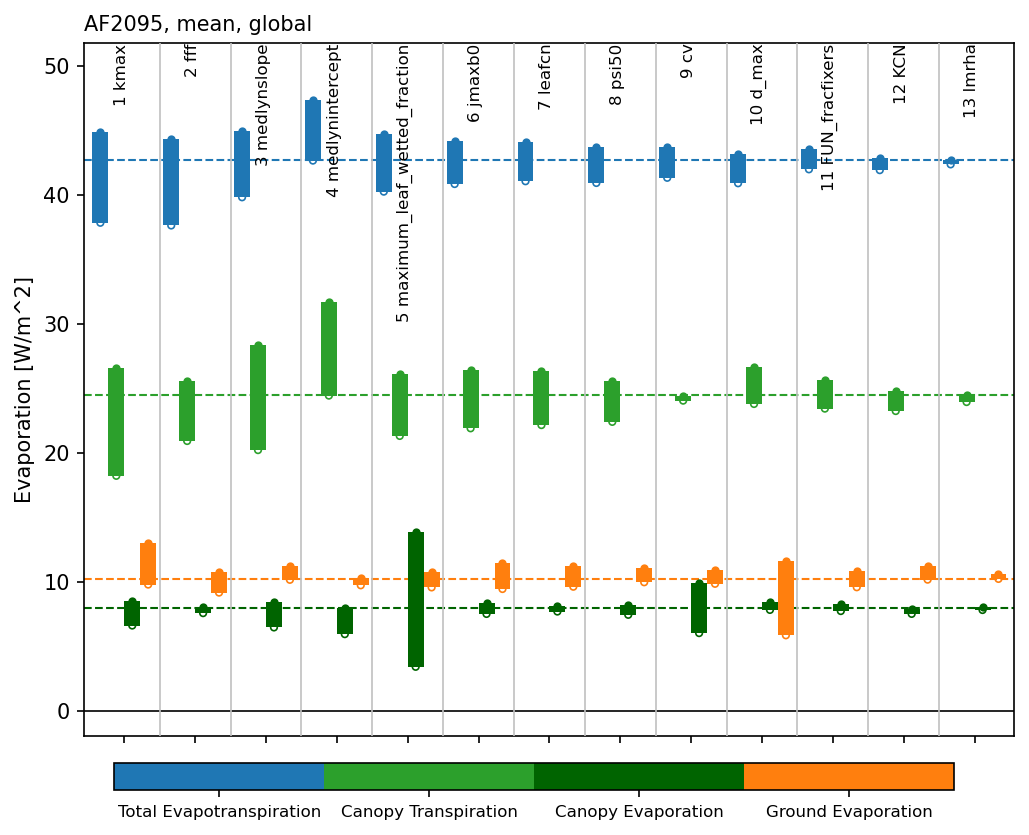

In [12]:
from matplotlib.colors import ListedColormap
from matplotlib.colorbar import ColorbarBase

plist = [
    'fff',
    'jmaxb0',
    'medlynslope',
    'medlynintercept',
    'maximum_leaf_wetted_fraction',
    'kmax',
    'leafcn',
    'd_max',
    'psi50',
    'cv', # or dleaf
    'KCN',
    'FUN_fracfixers',
    'lmrha', # or lmrhd
    # 'ACCLIM_SF',
    # 'SOIL_HYDRO',
]
vlist = ['EFLX_LH_TOT', 'FCTR', 'FCEV', 'FGEV']
measure = 'mean'
biome='GB'
forcing = 'AF2095'
pnum=None
sort_by_var='EFLX_LH_TOT'
add_cbar=True
return_cbar=False
fig=None
ax=None
save=False

###########

bm_dict = {
    'BF':    'Boreal forest',
    'SD':    'Subtropical desert',
    'TmGD':  'Temperate grassland/desert',
    'TmRF':  'Temperate rain forest',
    'TmSF':  'Temperate seasonal forest',
    'TrRF':  'Tropical rain forest',
    'TrSFS': 'Tropical seasonal forest/savanna',
    'Tu':    'Tundra',
    'WS':    'Woodland/shrubland',
    'GB':    'global',
}

clr_dict = {
    'EFLX_LH_TOT': 'tab:blue',
    'FCTR': 'tab:green',
    'FCEV': 'darkgreen',
    'FGEV': 'tab:orange',
}

rng = 'range'
rnk = 'rank'
pmn = 'xmin'
pmx = 'xmax'

# Load units if not already loaded
if 'units' not in locals():
    units = ppe.load_dict('units.csv')

# Create modifier if plotting biome
bm = ''
if biome is not None and biome != 'GB':
    bm = '_biomes'

# Load the data
df = dict()
df_def = dict()
defx = dict()
for var in vlist:
    # Load the PPE data and only keep relevant columns
    df[var] = pd.read_csv(f'./rank/csv/{forcing}_top193_params{bm}.csv')
    df[var] = df[var].loc[df[var]['measure']==measure].loc[df[var]['variable']==var]
    df[var] = df[var].loc[df[var]['param_name'].isin(plist)]
    df[var] = df[var].reset_index(drop=True)
    
    # Load the default data and only keep relevant columns
    df_def[var] = pd.read_csv(f'./rank/csv/default_params{bm}.csv')
    df_def[var] = df_def[var].loc[df_def[var]['forcing']==forcing].loc[df_def[var]['measure']==measure].loc[df_def[var]['variable']==var]
    df_def[var] = df_def[var].reset_index(drop=True)

    # Select the biome if provided
    if biome is not None:
        df[var] = df[var].loc[df[var]['biome']==bm_dict[biome]].reset_index(drop=True)
        df_def[var] = df_def[var].loc[df_def[var]['biome']==bm_dict[biome]].reset_index(drop=True)
    
    # Just get the x values for the default data
    defx[var] = df_def[var].x.values
    
# Sort if provided
sorted_param = plist
if sort_by_var is not None and sort_by_var in vlist:
    sorted_param = df[sort_by_var].sort_values(by='range', ascending=False).param_name
    for var in vlist:
        df[var] = df[var].set_index('param_name').loc[sorted_param].reset_index()

# Total number of parameters and variables
npar = len(plist)
nvar = len(vlist)

# Create figure and axes if not provided
if ax is None:
    fig, ax = plt.subplots(figsize=(8, 6))

wspace = 0.1
width = (1-wspace)/nvar

amn = np.inf
amx = -np.inf
for i, var in enumerate(vlist):
    offset = i * width
    mn = np.array([min(row['xmin'], row['xmax']) for index, row in df[var].iterrows()])
    mx = np.array([max(row['xmin'], row['xmax']) for index, row in df[var].iterrows()])
    
    ax.bar(np.arange(npar)+offset, height=df[var][rng], bottom=mn, width=width, facecolor=clr_dict[var], linewidth=0)

    ax.scatter(np.arange(npar)+offset, mn, 10, marker='o', edgecolor=clr_dict[var], facecolor='none', lw=mpl.rcParams['axes.linewidth'])
    ax.scatter(np.arange(npar)+offset, mx, 10, marker='o', edgecolor=clr_dict[var], facecolor=clr_dict[var], lw=mpl.rcParams['axes.linewidth'])

    ax.axhline(defx[var], c=clr_dict[var], ls='--', lw=mpl.rcParams['axes.linewidth']*1.25, zorder=0)

    if amn > min(mn): amn = min(mn)
    if amx < max(mx): amx = max(mx)

ax.set_xticks(np.arange(npar)+offset/2)
ax.set_xticklabels(np.arange(npar)+1)

ax.set_xlim(-width, npar-1+offset+width)
ax.set_ylim(-2, amx+(amx-amn)*0.1)

ax.set_ylabel('Evaporation [W/m^2]')

ax.axhline(0, c='k', lw=mpl.rcParams['axes.linewidth'], zorder=0)
for i in range(1,npar):
    ax.axvline(i-(wspace+width)/2, c='silver', lw=mpl.rcParams['axes.linewidth'], zorder=300)

for i in range(npar):
    ax.text(
        i+(nvar/3*width), ax.get_ylim()[1],
        f'{i+1} {sorted_param[i]}',
        fontsize=8, va='top', ha='center', rotation=90)

if add_cbar:
    ax.set_xticklabels([])
    
    cmap = ListedColormap([clr_dict[var] for var in vlist])
    cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.03])  # Position: [left, bottom, width, height]
    cbar = ColorbarBase(cbar_ax, cmap=cmap, orientation='horizontal', ticks=range(len(vlist)))
    cbar.set_ticks([i*0.25+0.125 for i in range(len(vlist))])
    cbar.set_ticklabels([varname[var] for var in vlist], fontsize=8)

ax.set_title(f'{forcing}, {measure}, {bm_dict[biome].lower()}', loc='left', fontsize=10)

In [19]:
plist = [
    'fff',
    'jmaxb0',
    'medlynslope',
    'medlynintercept',
    'maximum_leaf_wetted_fraction',
    'kmax',
    'leafcn',
    'd_max',
    'psi50',
    'cv',  # or dleaf
    'KCN',
    'FUN_fracfixers',
    'lmrha',  # or lmrhd
    # 'ACCLIM_SF',
    # 'SOIL_HYDRO',
]
vlist = ['EFLX_LH_TOT', 'FCTR', 'FCEV', 'FGEV']
measure = 'mean'
biome = 'BF'
forcing = 'AF2095'
pnum = None
sort_by_var = 'EFLX_LH_TOT'
add_cbar = True
return_cbar = False
fig = None
ax = None
save = False

###########


def plot_et_range_bar(
    plist,
    vlist=['EFLX_LH_TOT', 'FCTR', 'FCEV', 'FGEV'],
    measure='mean', biome='GB', forcing='AF2095',
    pnum=None, sort_by_var=None,
    add_cbar=True, return_cbar=False,
    fig=None, ax=None, do_pct=False,
    dpi=200,
):
    '''
    Plot the range of each ET component.
    '''

    ###########
    # Constants
    ###########


    bm_dict = {
        'BF':    'Boreal forest',
        'SD':    'Subtropical desert',
        'TmGD':  'Temperate grassland/desert',
        'TmRF':  'Temperate rain forest',
        'TmSF':  'Temperate seasonal forest',
        'TrRF':  'Tropical rain forest',
        'TrSFS': 'Tropical seasonal forest/savanna',
        'Tu':    'Tundra',
        'WS':    'Woodland/shrubland',
        'GB':    'global',
    }

    clr_dict = {
        'EFLX_LH_TOT': 'tab:blue',
        'FCTR': 'tab:green',
        'FCEV': 'darkgreen',
        'FGEV': 'tab:orange',
    }

    rng = 'range'
    rnk = 'rank'
    pmn = 'xmin'
    pmx = 'xmax'

    # Load units if not already loaded
    if 'units' not in locals():
        units = ppe.load_dict('units.csv')

    # Create modifier if plotting biome
    bm = ''
    if biome is not None and biome != 'GB':
        bm = '_biomes'
    
    ###########
    # Load data
    ###########

    df = dict()
    df_def = dict()
    defx = dict()
    for var in vlist:
        # Load the PPE data and only keep relevant columns
        df[var] = pd.read_csv(f'./rank/csv/{forcing}_top193_params{bm}.csv')
        df[var] = df[var].loc[df[var]['measure']==measure].loc[df[var]['variable']==var]
        df[var] = df[var].loc[df[var]['param_name'].isin(plist)]
        df[var] = df[var].reset_index(drop=True)
        
        # Load the default data and only keep relevant columns
        df_def[var] = pd.read_csv(f'./rank/csv/default_params{bm}.csv')
        df_def[var] = df_def[var].loc[df_def[var]['forcing']==forcing].loc[df_def[var]['measure']==measure].loc[df_def[var]['variable']==var]
        df_def[var] = df_def[var].reset_index(drop=True)

        # Select the biome if provided
        if biome is not None:
            df[var] = df[var].loc[df[var]['biome']==bm_dict[biome]].reset_index(drop=True)
            df_def[var] = df_def[var].loc[df_def[var]['biome']==bm_dict[biome]].reset_index(drop=True)
        
        # Just get the x values for the default data
        defx[var] = df_def[var].x.values
        
    # Sort if provided
    sorted_param = plist
    if sort_by_var is not None and sort_by_var in vlist:
        sorted_param = df[sort_by_var].sort_values(by='range', ascending=False).param_name
        for var in vlist:
            df[var] = df[var].set_index('param_name').loc[sorted_param].reset_index()

    # Total number of parameters and variables
    npar = len(plist)
    nvar = len(vlist)

    ##########
    # Plotting
    ##########

    # Create figure and axes if not provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6), dpi=dpi)

    wspace = 0.1
    width = (1-wspace)/nvar

    amn = np.inf
    amx = -np.inf
    for i, var in enumerate(vlist):
        offset = i * width
        mn = np.array([min(row['xmin'], row['xmax']) for index, row in df[var].iterrows()])
        mx = np.array([max(row['xmin'], row['xmax']) for index, row in df[var].iterrows()])
        
        ax.bar(np.arange(npar)+offset, height=df[var][rng], bottom=mn, width=width, facecolor=clr_dict[var], linewidth=0)

        ax.scatter(np.arange(npar)+offset, mn, 10, marker='o', edgecolor=clr_dict[var], facecolor='none', lw=mpl.rcParams['axes.linewidth'])
        ax.scatter(np.arange(npar)+offset, mx, 10, marker='o', edgecolor=clr_dict[var], facecolor=clr_dict[var], lw=mpl.rcParams['axes.linewidth'])

        ax.axhline(defx[var], c=clr_dict[var], ls='--', lw=mpl.rcParams['axes.linewidth']*1.25, zorder=0)

        if amn > min(mn): amn = min(mn)
        if amx < max(mx): amx = max(mx)

    ax.set_xticks(np.arange(npar)+offset/2)
    ax.set_xticklabels(np.arange(npar)+1)

    ax.set_xlim(-width, npar-1+offset+width)
    ax.set_ylim(-2, amx+(amx-amn)*0.1)

    ax.set_ylabel('Evaporation [W/m^2]')

    ax.axhline(0, c='k', lw=mpl.rcParams['axes.linewidth'], zorder=0)
    for i in range(1,npar):
        ax.axvline(i-(wspace+width)/2, c='silver', lw=mpl.rcParams['axes.linewidth'], zorder=300)

    for i in range(npar):
        ax.text(
            i+(nvar/3*width), ax.get_ylim()[1],
            f'{i+1} {sorted_param[i]}',
            fontsize=8, va='top', ha='center', rotation=90)

    if add_cbar:
        ax.set_xticklabels([])
        
        cmap = ListedColormap([clr_dict[var] for var in vlist])
        cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.03])  # Position: [left, bottom, width, height]
        cbar = ColorbarBase(cbar_ax, cmap=cmap, orientation='horizontal', ticks=range(len(vlist)))
        cbar.set_ticks([i*0.25+0.125 for i in range(len(vlist))])
        cbar.set_ticklabels([varname[var] for var in vlist], fontsize=8)

    ax.set_title(f'{forcing}, {measure}, {bm_dict[biome].lower()}', loc='left', fontsize=10)

    if return_cbar:
        return ax, cbar

    return ax

<Axes: title={'left': 'AF1855, mean, boreal forest'}, ylabel='Evaporation [W/m^2]'>

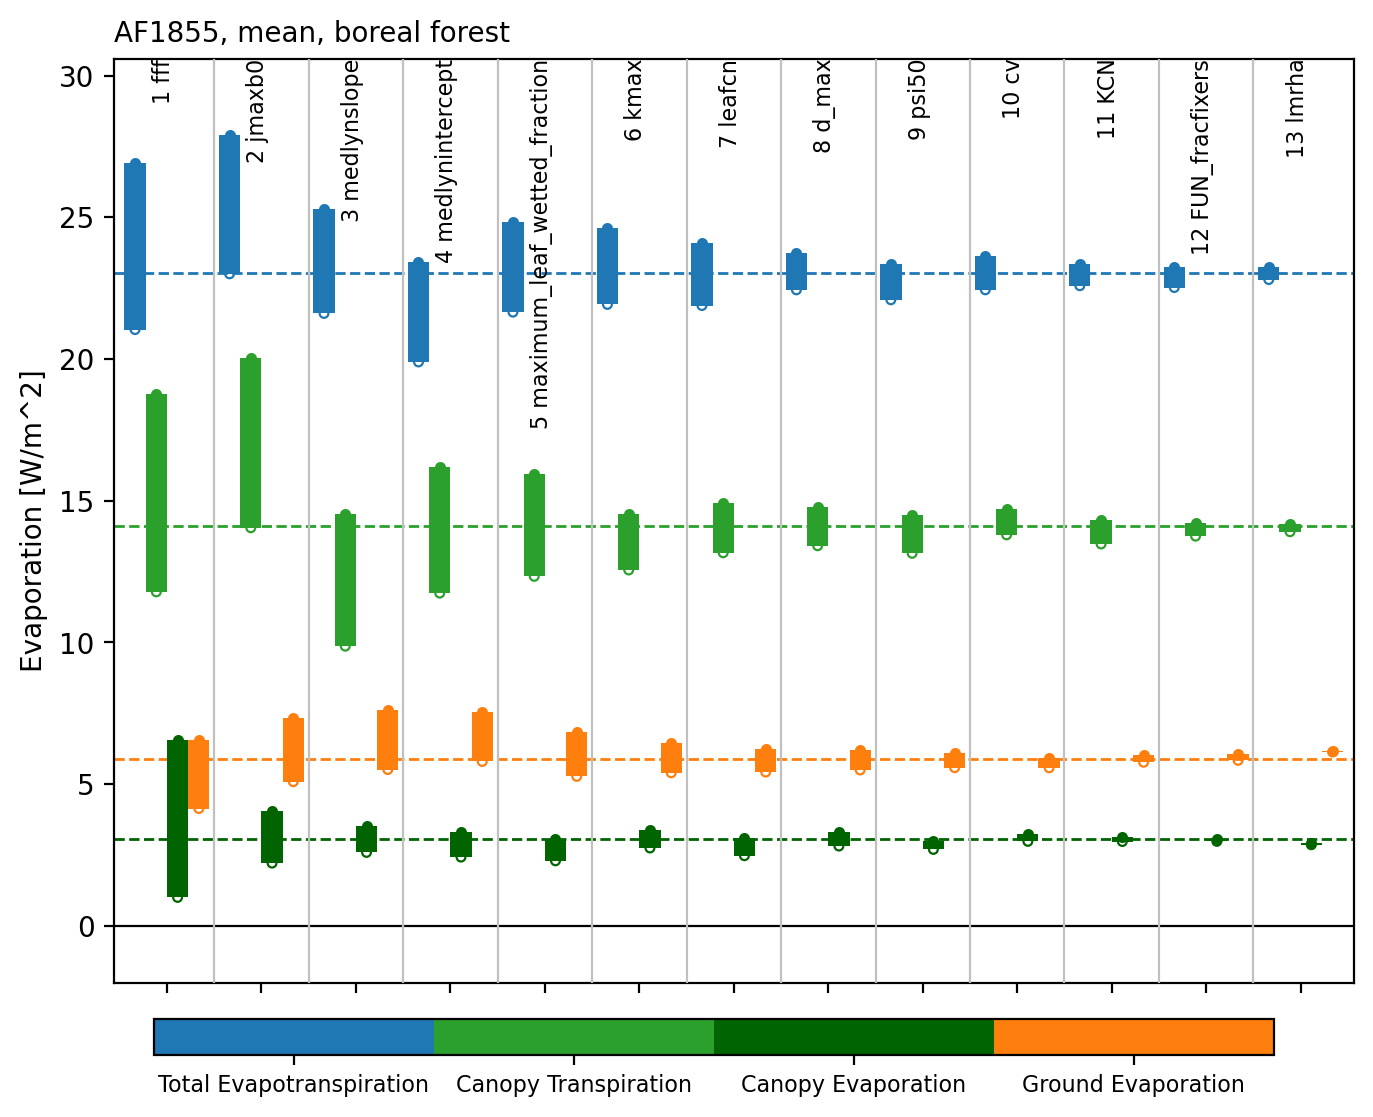

In [20]:
plist = [
    'fff',
    'jmaxb0',
    'medlynslope',
    'medlynintercept',
    'maximum_leaf_wetted_fraction',
    'kmax',
    'leafcn',
    'd_max',
    'psi50',
    'cv',  # or dleaf
    'KCN',
    'FUN_fracfixers',
    'lmrha',  # or lmrhd
    # 'ACCLIM_SF',
    # 'SOIL_HYDRO',
]
vlist = ['EFLX_LH_TOT', 'FCTR', 'FCEV', 'FGEV']
measure = 'mean'
biome = 'GB'
forcing = 'AF2095'
pnum = None
sort_by_var = 'EFLX_LH_TOT'
add_cbar = True
return_cbar = False
fig = None
ax = None
save = False

plot_et_range_bar(
    plist,
    vlist=['EFLX_LH_TOT', 'FCTR', 'FCEV', 'FGEV'],
    measure='mean', biome='BF', forcing='AF1855',
    pnum=None, sort_by_var=None,
    add_cbar=True, return_cbar=False,
    fig=None, ax=None, do_pct=False
)

In [ ]:
from matplotlib.colors import ListedColormap
from matplotlib.colorbar import ColorbarBase

plist = [
    'fff',
    'jmaxb0',
    'medlynslope',
    'medlynintercept',
    'maximum_leaf_wetted_fraction',
    'kmax',
    'leafcn',
    'd_max',
    'psi50',
    'cv', # or dleaf
    'KCN',
    'FUN_fracfixers',
    'lmrha', # or lmrhd
    # 'ACCLIM_SF',
    # 'SOIL_HYDRO',
]
vlist = ['EFLX_LH_TOT', 'FCTR', 'FCEV', 'FGEV']
measure = 'mean'
biome='GB'
forcing = 'AF2095'
pnum=None
sort_by_var='EFLX_LH_TOT'
add_cbar=True
return_cbar=False
fig=None
ax=None
save=False
do_pct=True

###########

def plot_et_minmax_bar(
    plist,
    vlist=['EFLX_LH_TOT', 'FCTR', 'FCEV', 'FGEV'],
    measure='mean', biome='GB', forcing='AF2095',
    pnum=None, sort_by_var=None,
    add_cbar=True, return_cbar=False,
    fig=None, ax=None, do_pct=False
):
    """
    Plot the min/max of the parameters for each variable.
    """

    ###########
    # Constants
    ###########

    bm_dict = {
        'BF':    'Boreal forest',
        'SD':    'Subtropical desert',
        'TmGD':  'Temperate grassland/desert',
        'TmRF':  'Temperate rain forest',
        'TmSF':  'Temperate seasonal forest',
        'TrRF':  'Tropical rain forest',
        'TrSFS': 'Tropical seasonal forest/savanna',
        'Tu':    'Tundra',
        'WS':    'Woodland/shrubland',
        'GB':    'global',
    }

    clr_dict = {
        'EFLX_LH_TOT': 'tab:blue',
        'FCTR': 'tab:green',
        'FCEV': 'darkgreen',
        'FGEV': 'tab:orange',
    }

    rng = 'range'
    rnk = 'rank'
    pmn = 'xmin'
    pmx = 'xmax'

    # Load units if not already loaded
    if 'units' not in locals():
        units = ppe.load_dict('units.csv')

    # Create modifier if plotting biome
    bm = ''
    if biome is not None and biome != 'GB':
        bm = '_biomes'

    ###########
    # Load data
    ###########

    df = dict()
    for var in vlist:
        # Load the PPE data and only keep relevant columns
        df[var] = pd.read_csv(f'./rank/csv/{forcing}_top193_params{bm}.csv')
        df[var] = df[var].loc[df[var]['measure']==measure].loc[df[var]['variable']==var]
        df[var] = df[var].loc[df[var]['param_name'].isin(plist)]
        df[var] = df[var].reset_index(drop=True)

        # Select the biome if provided
        if biome is not None and biome != 'GB':
            df[var] = df[var].loc[df[var]['biome']==bm_dict[biome]].reset_index(drop=True)
    
    # Sort if provided
    sorted_param = plist
    if sort_by_var is not None and sort_by_var in vlist:
        sorted_param = df[sort_by_var].sort_values(by='range', ascending=False).param_name
        for var in vlist:
            df[var] = df[var].set_index('param_name').loc[sorted_param].reset_index()

    # Total number of parameters and variables
    npar = len(plist)
    nvar = len(vlist)

    # Create figure and axes if not provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))

    wspace = 0.2
    width = (1-wspace)/2

    vlist_no_tot = [var for var in vlist if var != 'EFLX_LH_TOT']
    for i, mm in enumerate(['xmax', 'xmin']):
        offset = i * width

        varfrac = np.zeros(npar)
        bottom = np.zeros(npar)
        for j, var in enumerate(vlist_no_tot):
            if do_pct:
                varfrac = np.array([row[mm] for index, row in df[var].iterrows()]) / np.array([row[mm] for index, row in df['EFLX_LH_TOT'].iterrows()]) * 100
            else:
                varfrac = np.array([row[mm] for index, row in df[var].iterrows()])
            ax.bar(np.arange(npar)+offset, height=varfrac, bottom=bottom, width=width, facecolor=clr_dict[var], edgecolor='silver', linewidth=0.5)
            bottom += varfrac

    ax.set_xticks(np.arange(npar)+offset/2)
    ax.set_xticklabels(np.arange(npar)+1)
    ax.set_title('max (left bar) and min (right bar)', loc='left', fontsize=8)

    ax.set_xlim(-width, npar-1+offset+width)
    if do_pct:
        ax.set_ylim(0, 100)
        ax.set_ylabel('Fraction of Total Evaporation [%]')
    else:
        ax.set_ylabel('Evaporation [W/m^2]')

    for i in range(npar):
        ax.text(
            i+(nvar/6*width), (ax.get_ylim()[1]-ax.get_ylim()[0])*0.025,
            f'{i+1} {sorted_param[i]}',
            fontsize=8, va='bottom', ha='center', rotation=90)

    if add_cbar:
        ax.set_xticklabels([])
        
        cmap = ListedColormap([clr_dict[var] for var in vlist])
        cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.03])  # Position: [left, bottom, width, height]
        cbar = ColorbarBase(cbar_ax, cmap=cmap, orientation='horizontal', ticks=range(len(vlist)))
        cbar.set_ticks([i*0.25+0.125 for i in range(len(vlist))])
        cbar.set_ticklabels([varname[var] for var in vlist], fontsize=8)
    
    if return_cbar:
        return ax, cbar
    
    return ax

<Axes: title={'left': 'max (left bar) and min (right bar)'}, ylabel='Evaporation [W/m^2]'>

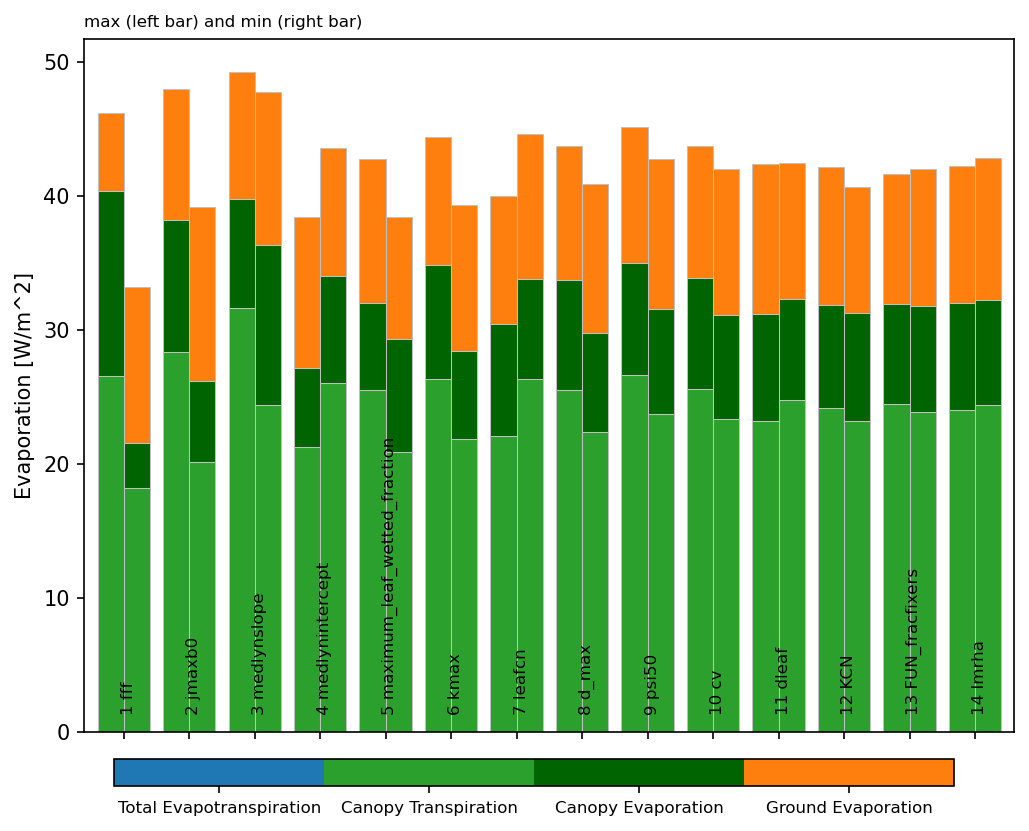

In [ ]:
plot_et_minmax_bar(
    plist = [
    'fff',
    'jmaxb0',
    'medlynslope',
    'medlynintercept',
    'maximum_leaf_wetted_fraction',
    'kmax',
    'leafcn',
    'd_max',
    'psi50',
    'cv',
    'dleaf',
    'KCN',
    'FUN_fracfixers',
    'lmrha', # or lmrhd
    # 'ACCLIM_SF',
    # 'SOIL_HYDRO',
]
)